# Setup notebook

In [125]:
import sys
from collections import namedtuple

import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import statsmodels.api as sm
import utide
from joblib import Parallel, delayed
from matplotlib import dates as mdates
from matplotlib import pyplot as plt
from scipy.signal import find_peaks
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import STL, seasonal_decompose

sys.path.append("..")
from src import definitions as defs
from src import features, models

%load_ext autoreload
%autoreload 2
%matplotlib widget
%config Completer.use_jedi = False

plt.rcParams['figure.constrained_layout.use'] = True

# plt.close("all")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [126]:
wdir = defs.ROOT / "data"

In [127]:
MSL = 12.1
data = pd.read_csv(wdir / "raw" / "sutarkhali_raw.csv", index_col="datetime", parse_dates=True, infer_datetime_format=True, squeeze=True)
data = data - MSL

In [128]:
data = data.loc[~data.index.duplicated(keep="last")]
bad = data.loc["2015-09-09 16:30:00":"2015-09-09 18:00:00"].index
data = data.loc[~data.index.isin(bad)].reindex(index=pd.date_range(start=data.index[0], end=data.index[-1], freq="10T"))

In [129]:
def find_gaps(data):
    nulls = data.loc[data.isnull()]
    starts = nulls.loc[nulls.index - nulls.index.to_series().shift(1) != pd.Timedelta("10T")]
    ends = nulls.loc[nulls.index.to_series().shift(-1) - nulls.index != pd.Timedelta("10T")]
    gaps = starts.index.to_frame(name="start").reset_index(drop=True)
    gaps["end"] = ends.index
    gaps["length"] = gaps.end - gaps.start
    return(gaps)

In [130]:
gaps = find_gaps(data)

window = pd.Timedelta("29.5D")
gaps[["left_median", "right_median"]] = np.nan

for gap in gaps.itertuples():
    gaps.loc[gap.Index, "left_median"] = data.loc[gap.start-window:gap.start].median()
    gaps.loc[gap.Index, "right_median"] = data.loc[gap.end:gap.end+window].median()

gaps["gap_diff"] = gaps.left_median - gaps.right_median

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
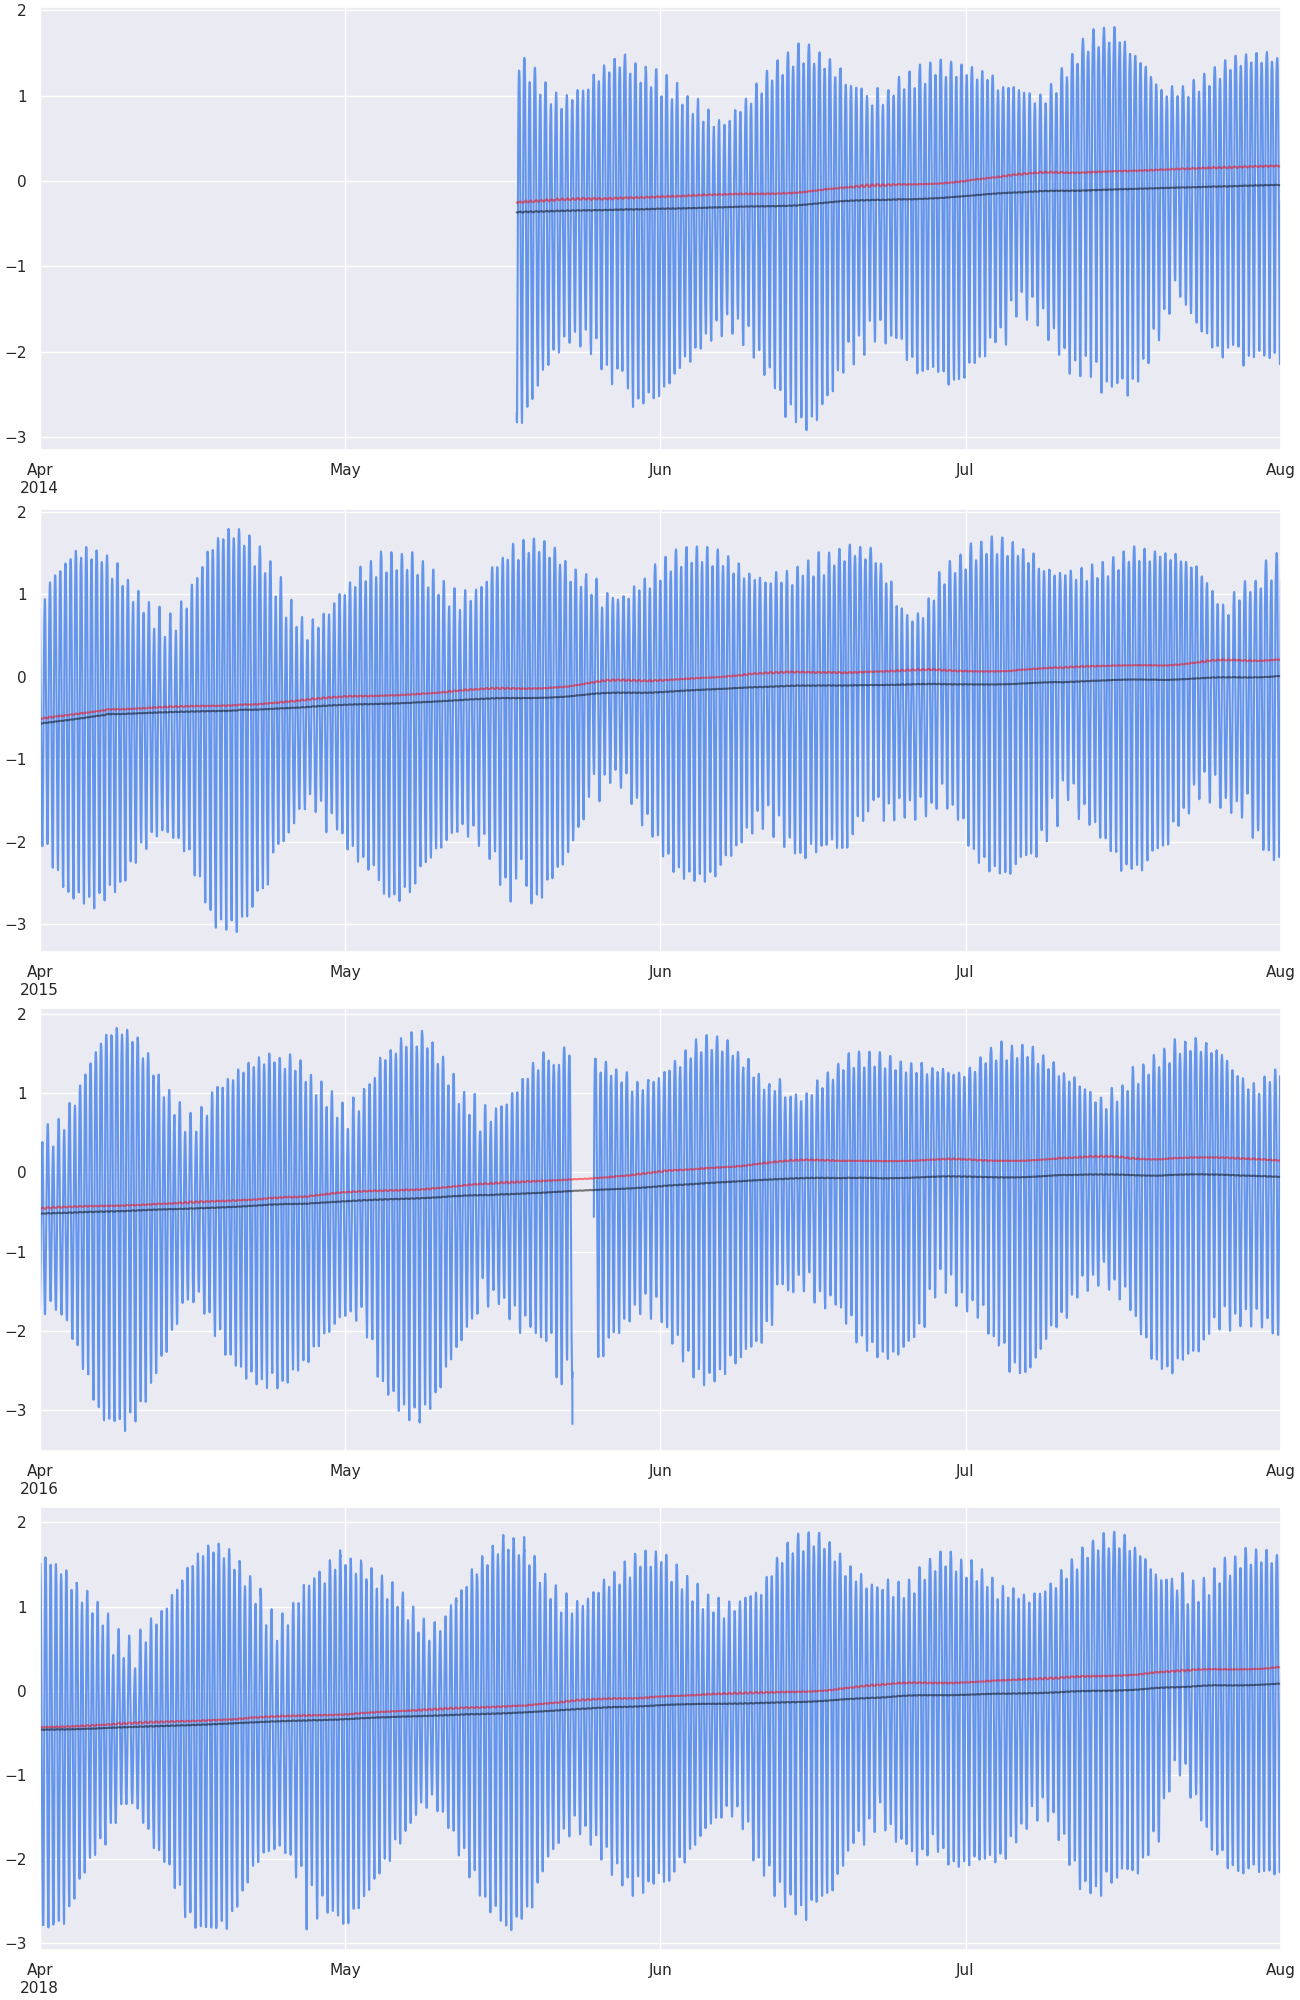

In [152]:
years = data.index.year.unique().drop(labels=2017)

fig, ax = plt.subplots(figsize=(13, 5*len(years)), nrows=len(years), constrained_layout=True)

window = pd.Timedelta("14D") * 4

i = 0
for year in years:
    start = "{}-04".format(year)
    end = "{}-08".format(year)
    median = data.loc[start:end].median()
    subset = data.loc[start:end] - median
    subset.loc[start:end].plot(color="cornflowerblue", ax=ax[i], label="Obs")
    (data.rolling(window=window, center=True, min_periods=pd.Timedelta("7D")//data.index.freq).median() - median).loc[start:end].plot(color="red", alpha=0.5, ax=ax[i], label="Median")
    (data.rolling(window=window, center=True, min_periods=pd.Timedelta("7D")//data.index.freq).mean().loc[start:end] - median).plot(color="black", alpha=0.5, ax=ax[i], label="Mean")
    ax[i].set_xlim(start, end)
    i += 1

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
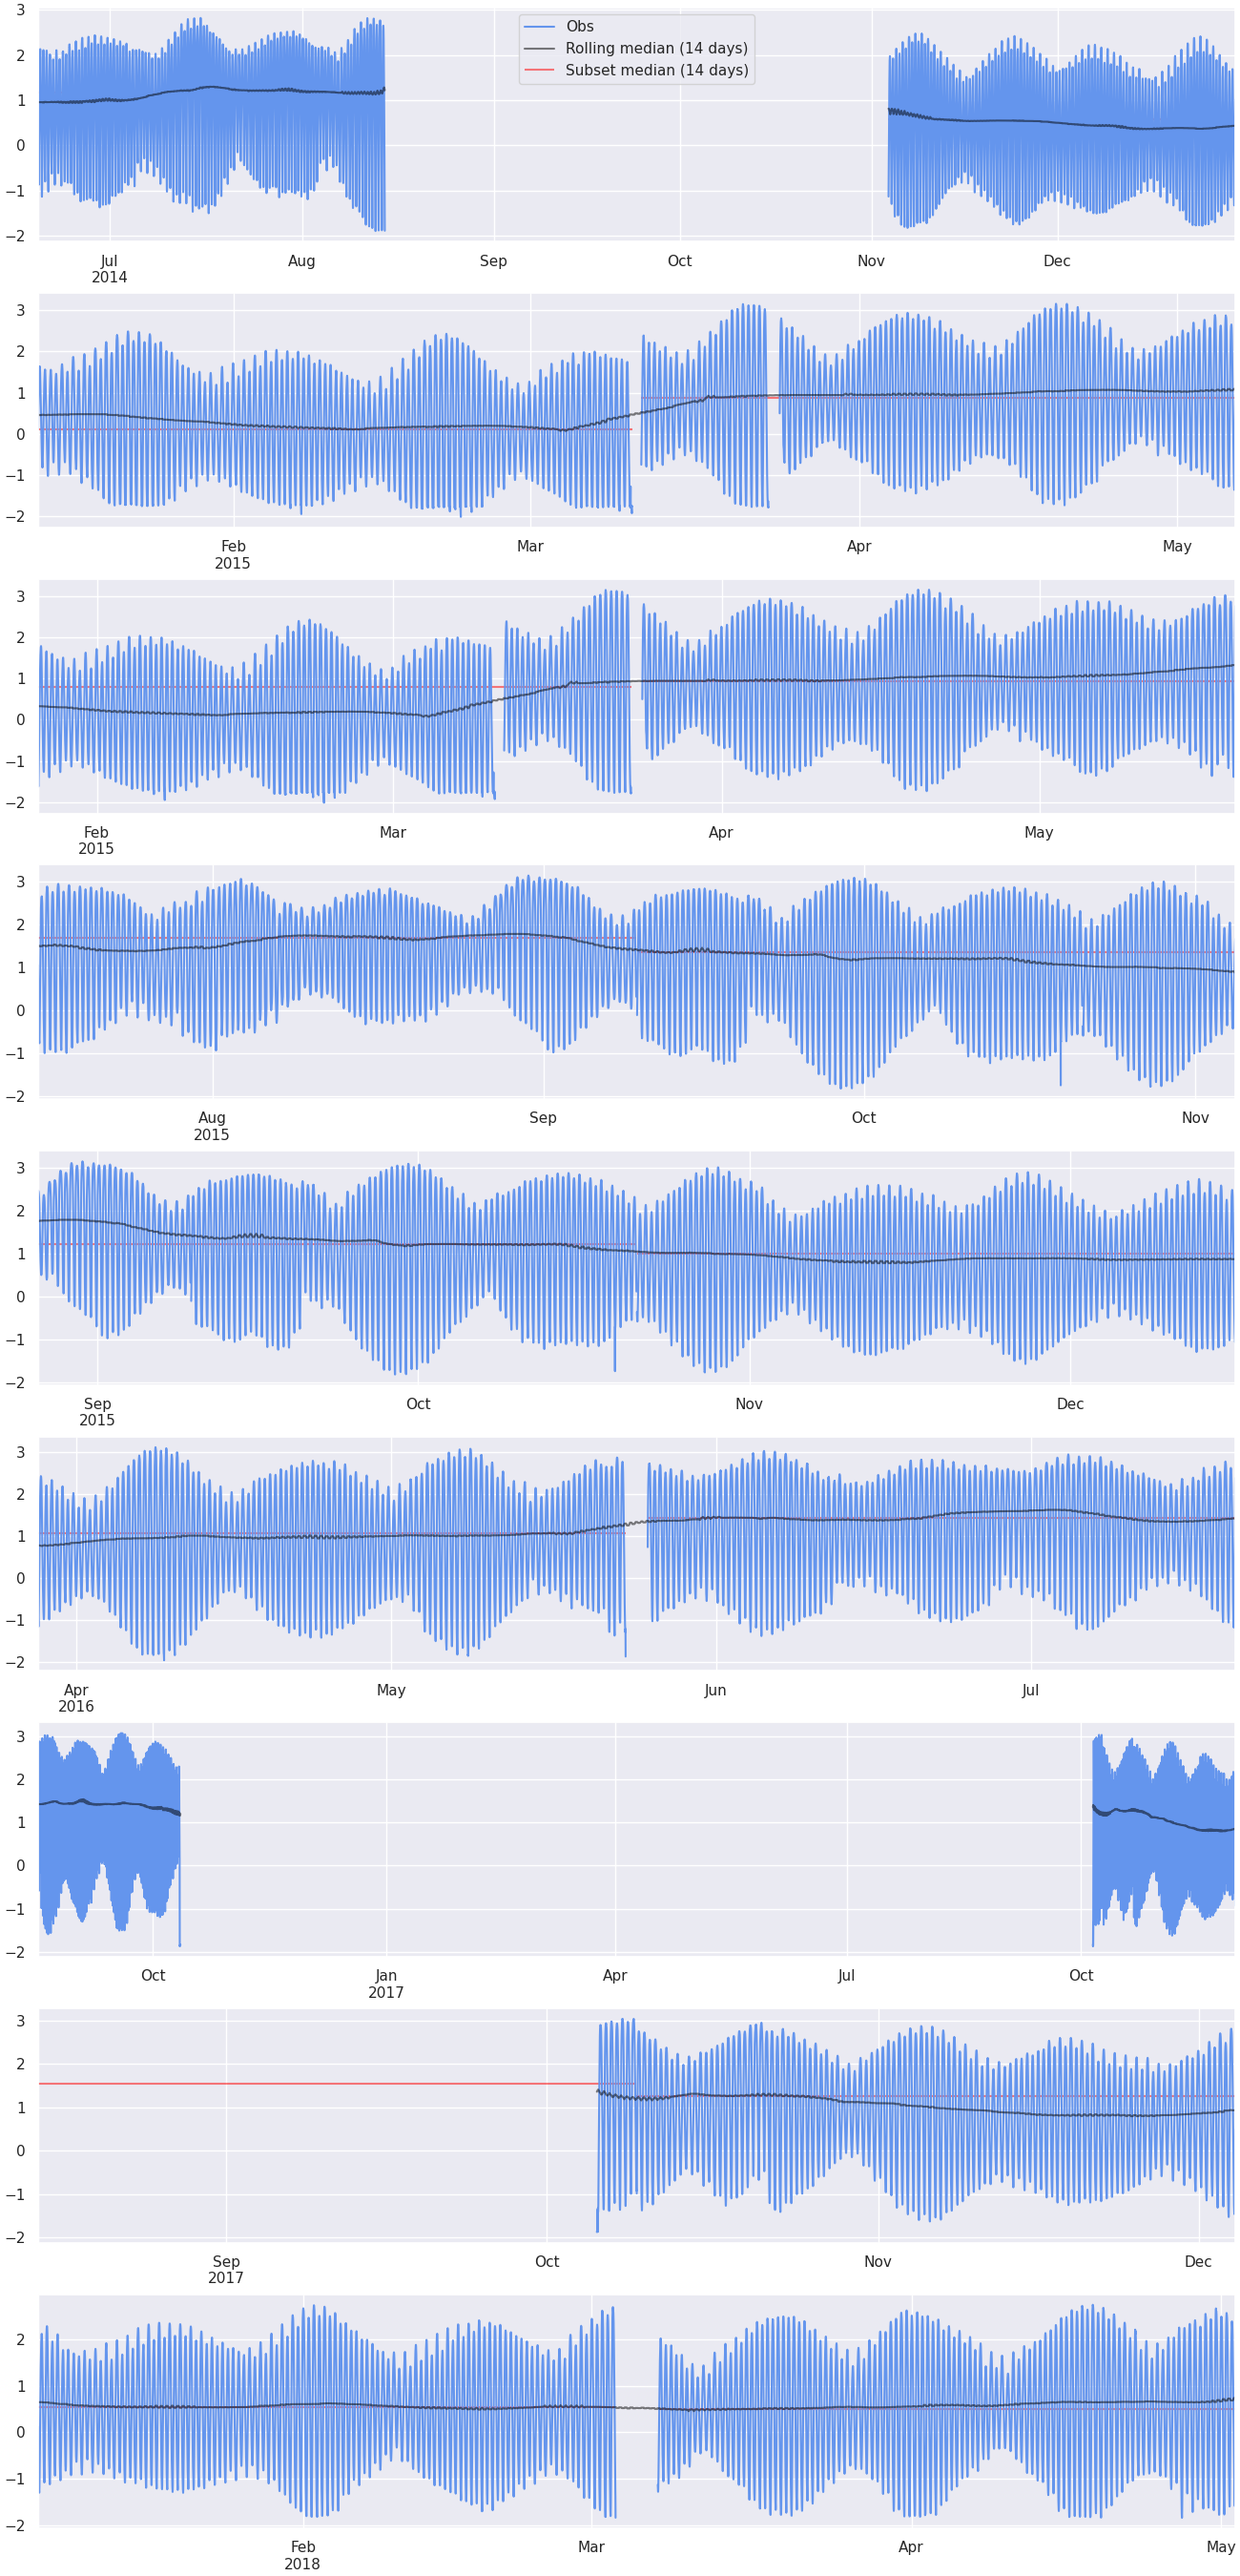

In [148]:
fig, ax = plt.subplots(figsize=(13, 3*len(gaps)), nrows=len(gaps), constrained_layout=True)

window = pd.Timedelta("14D")
pwindow = pd.Timedelta("14D") * 2 * 2

new = data.copy()

for gap in gaps.itertuples():

    start = gap.start - pwindow
    end = gap.end + pwindow

    new.loc[start:end].plot(color="cornflowerblue", ax=ax[gap.Index], label="Obs")
    new.rolling(window=window, center=True, min_periods=pd.Timedelta("7D")//new.index.freq).median().loc[start:end].plot(color="black", alpha=0.5, ax=ax[gap.Index], label="Rolling median (14 days)")
    # new.loc[:gap.start].rolling(window=window, center=True, min_periods=pd.Timedelta("14D")//new.index.freq).median().loc[start:gap.start].plot(color="black", alpha=0.5, ax=ax[gap.Index], label="Rolling median (28 days)")
    # new.loc[gap.end:].iloc[::-1].rolling(window=window, center=True, min_periods=pd.Timedelta("14D")//new.index.freq).median().sort_index().loc[gap.end:end].plot(color="black", alpha=0.5, ax=ax[gap.Index], label="Rolling median (28 days)")

    left_median = new.loc[gap.start-window:gap.start].median()
    right_median = new.loc[gap.end:gap.end+window].median()

    ax[gap.Index].hlines(y=left_median, xmin=start, xmax=gap.start, color="red", alpha=0.5, label="Subset median (14 days)")
    ax[gap.Index].hlines(y=right_median, xmin=gap.end, xmax=end, color="red", alpha=0.5)

    ax[gap.Index].set_xlabel("")

ax[0].legend()

In [153]:
to_adjust = gaps.loc[[1, 3, 4, 7]].reset_index(drop=True)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
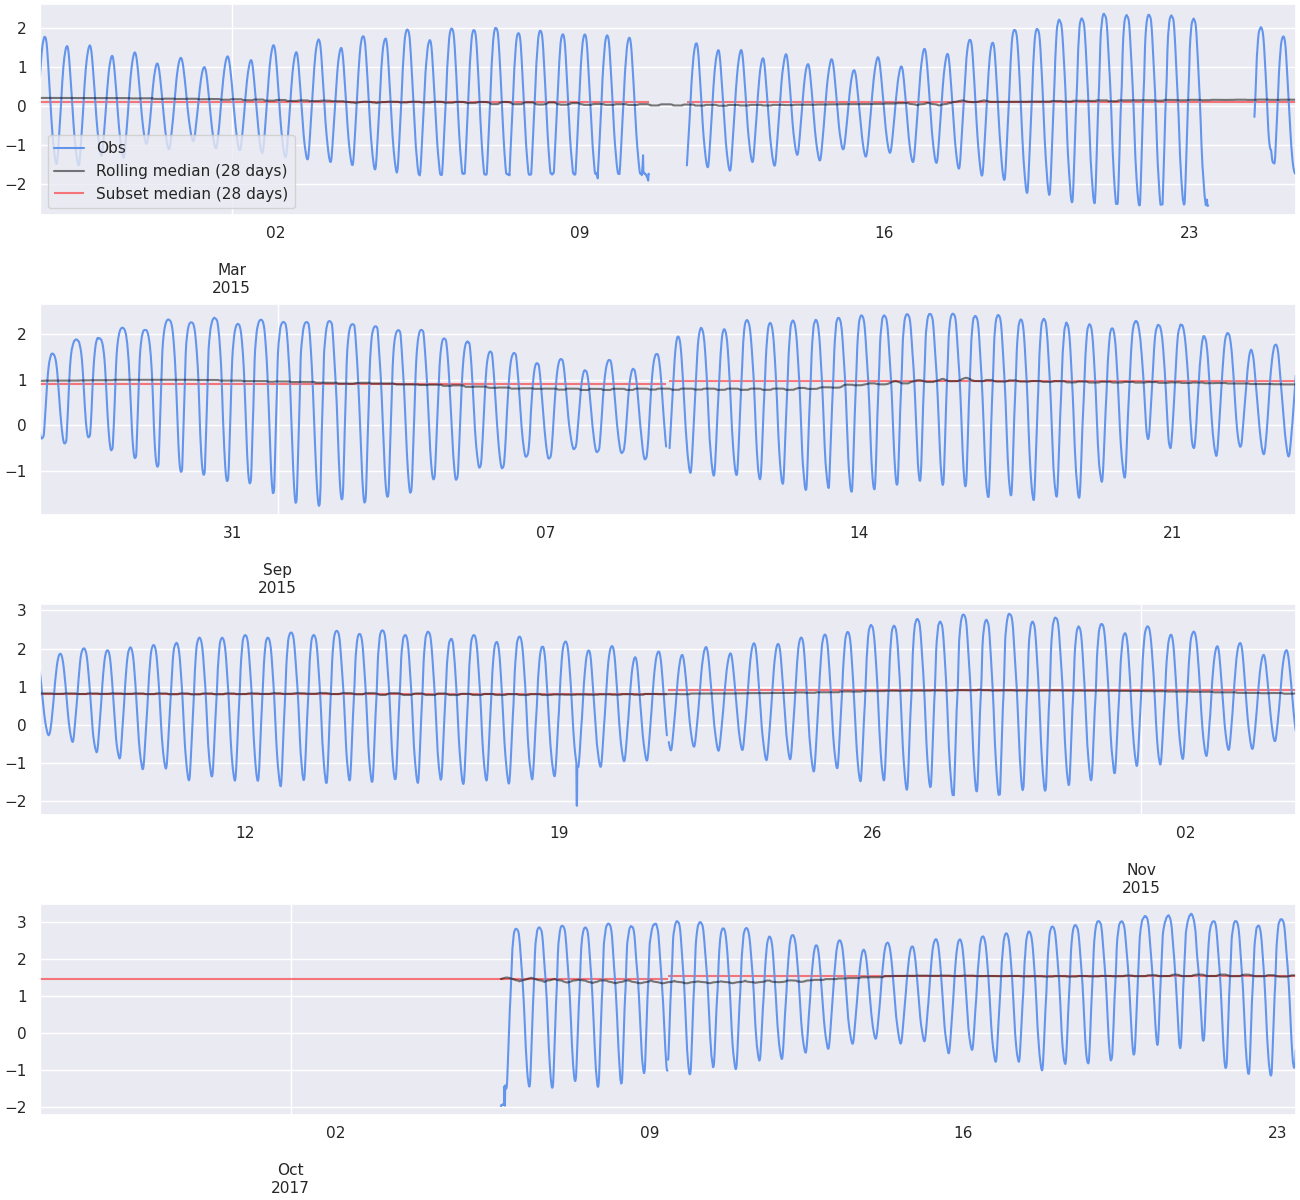

In [154]:
fig, ax = plt.subplots(figsize=(13, 3*len(to_adjust)), nrows=len(to_adjust), constrained_layout=True)

window = pd.Timedelta("14D")
pwindow = pd.Timedelta("14D")

new = data.copy()

for gap in to_adjust.itertuples():

    new.loc[gap.end:] = new.loc[gap.end:] + gap.gap_diff

    start = gap.start - pwindow
    end = gap.end + pwindow

    new.loc[start:end].plot(color="cornflowerblue", ax=ax[gap.Index], label="Obs")
    new.rolling(window=window, center=True, min_periods=pd.Timedelta("7D")//new.index.freq).median().loc[start:end].plot(color="black", alpha=0.5, ax=ax[gap.Index], label="Rolling median (28 days)")

    left_median = new.loc[gap.start-window:gap.start].median()
    right_median = new.loc[gap.end:gap.end+window].median()

    ax[gap.Index].hlines(y=left_median, xmin=start, xmax=gap.start, color="red", alpha=0.5, label="Subset median (28 days)")
    ax[gap.Index].hlines(y=right_median, xmin=gap.end, xmax=end, color="red", alpha=0.5)

    ax[gap.Index].set_xlabel("")

ax[0].legend()

In [155]:
data = new

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
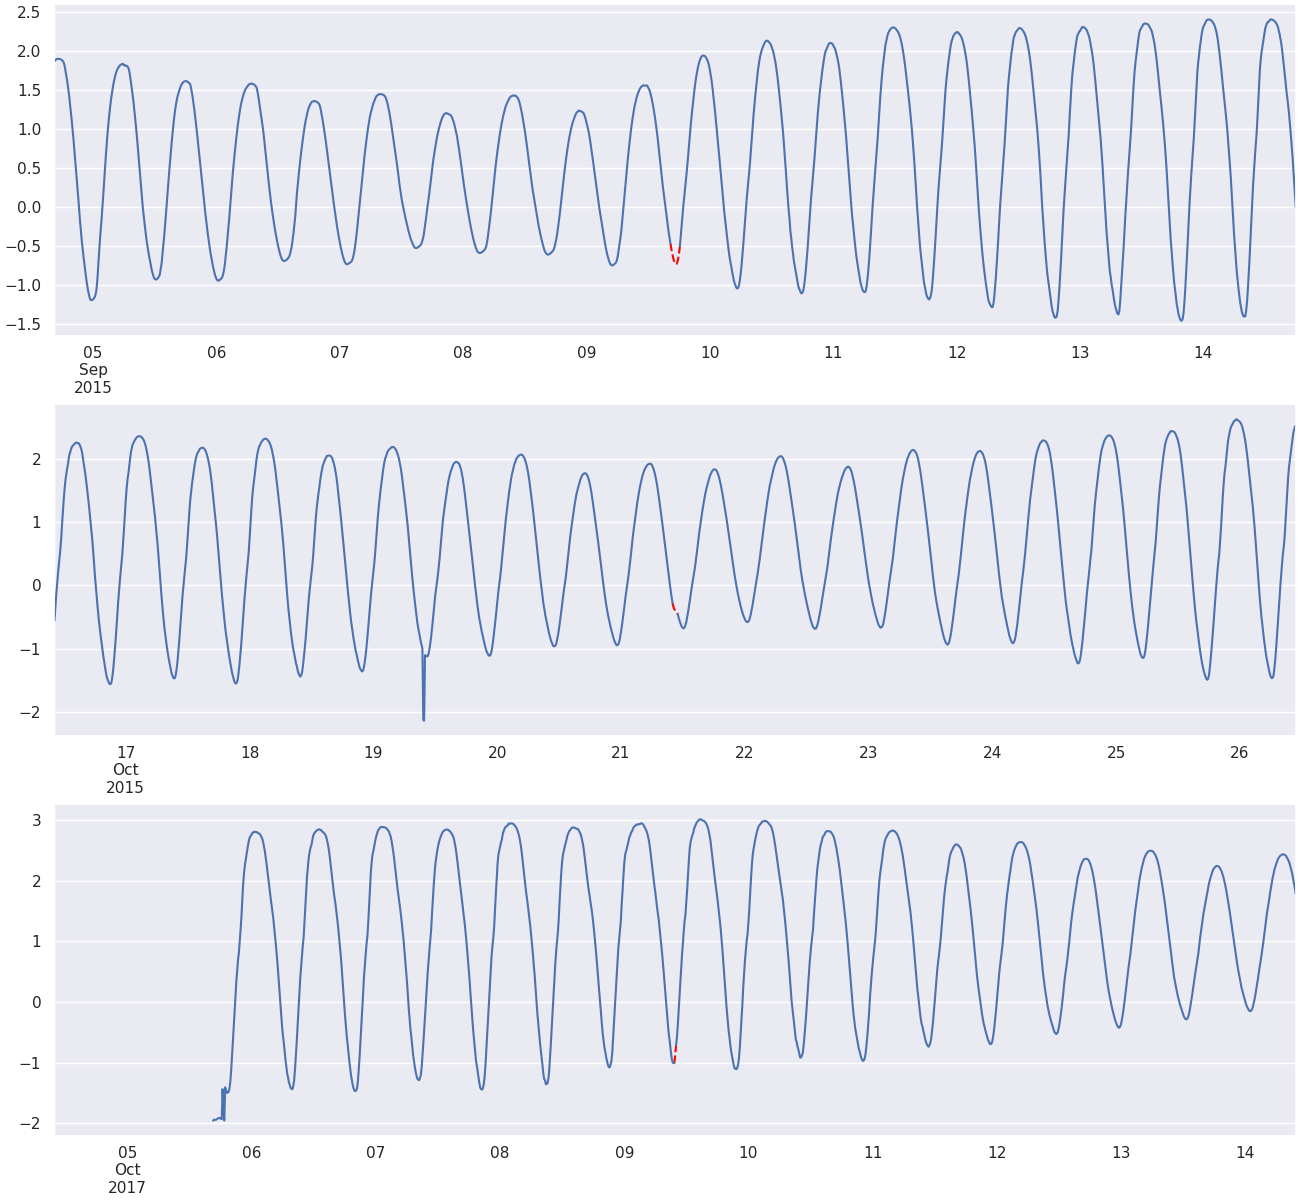

In [156]:
small_gaps = gaps.loc[gaps.length<pd.Timedelta("2H")].reset_index(drop=True)

interp = data.interpolate(method="cubicspline", limit_direction="both")

fig, ax = plt.subplots(figsize=(13, 4*len(small_gaps)), nrows=len(small_gaps), constrained_layout=True)

for gap in small_gaps.itertuples():
    interp.loc[gap.start-pd.Timedelta("10T"):gap.end+pd.Timedelta("10T")].plot(ax=ax[gap.Index], color="red", ls="--")
    data.loc[gap.start-pd.Timedelta("5D"):gap.end+pd.Timedelta("5D")].plot(ax=ax[gap.Index], alpha=1)



In [157]:
for gap in small_gaps.itertuples():
    data.loc[gap.start:gap.end] = interp.loc[gap.start:gap.end]
    gaps = gaps.loc[~(gaps.start == gap.start)].reset_index(drop=True)

In [158]:
gaps = find_gaps(data)

In [159]:
window = pd.Timedelta("28D")
gaps[["left_median", "right_median"]] = np.nan

for gap in gaps.itertuples():
    gaps.loc[gap.Index, "left_median"] = data.loc[gap.start-window:gap.start].median()
    gaps.loc[gap.Index, "right_median"] = data.loc[gap.end:gap.end+window].median()

gaps["gap_diff"] = gaps.left_median - gaps.right_median

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
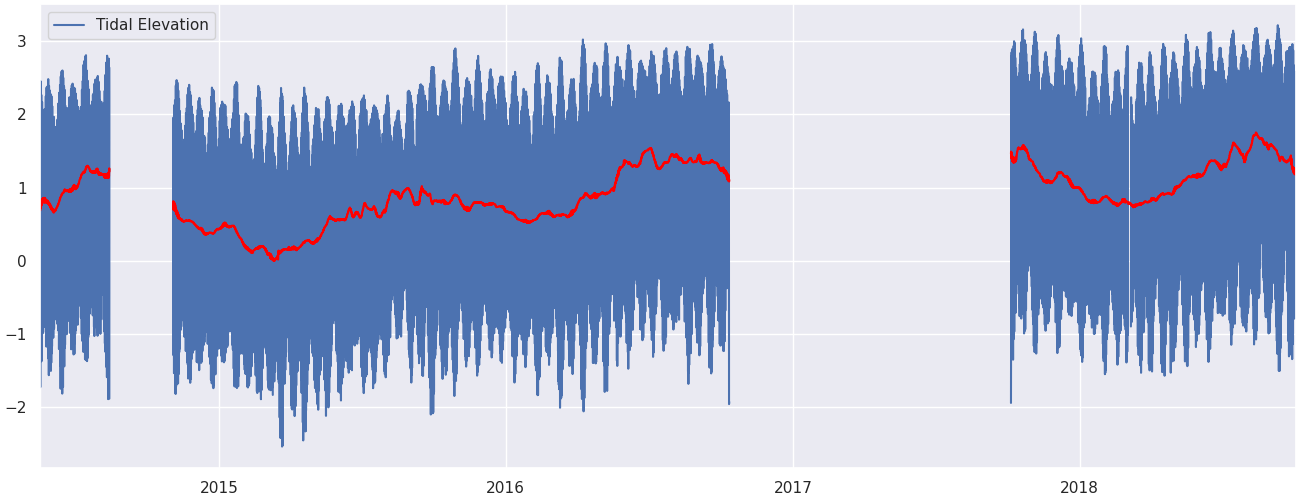

In [160]:
fig, ax = plt.subplots(figsize=(13, 5), constrained_layout=True)

window = pd.Timedelta("14D")
min_periods = window / 2 // data.index.freq
n = 12

data.iloc[::n].plot(kind="line", ax=ax, label="Tidal Elevation", legend=True)
data.rolling(window=window, center=True, min_periods=min_periods).median().iloc[::n].plot(kind="line", ax=ax, color="red")

ax.set_xlim(data.index[0], data.index[-1])
ax.set_xlabel("");

(0.0, 11711.0)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
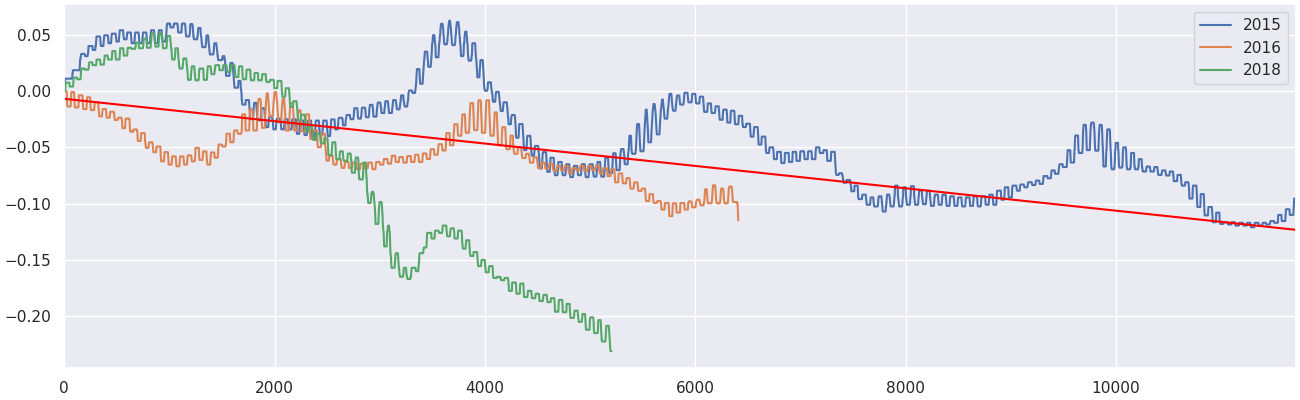

In [161]:
gap = gaps.loc[0]

window = pd.Timedelta("14D") * 2
min_periods = window // data.index.freq

roll = data.rolling(window=window, center=True, min_periods=min_periods).median()

fig, ax = plt.subplots(figsize=(13, 4), constrained_layout=True)

ser = []
for year in [2015, 2016, 2018]:
    start = gap.start + pd.DateOffset(year=year)
    end = gap.end + pd.DateOffset(year=year)
    s = roll.loc[start:end] - roll.loc[start]
    s.reset_index(drop=True).plot(ax=ax, label=year, legend=True)
    ser.append((roll.loc[start:end] - roll.loc[start]).reset_index(drop=True))

from sklearn.linear_model import LinearRegression
df = pd.concat(ser).reset_index().rename(columns={"index": "x", "pressure": "y"}).dropna().sort_values("x")
x = df.x.values.reshape(-1, 1)
y = df.y.values.reshape(-1, 1)

lm = LinearRegression()
lm.fit(X=x, y=y)

preds = lm.predict(X=x).reshape(1, -1)[0]

sns.lineplot(x=x.reshape(1, -1)[0][[0, -1]], y=preds[[0, -1]], color="red")
ax.set_xlim(x[0], x[-1])



Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
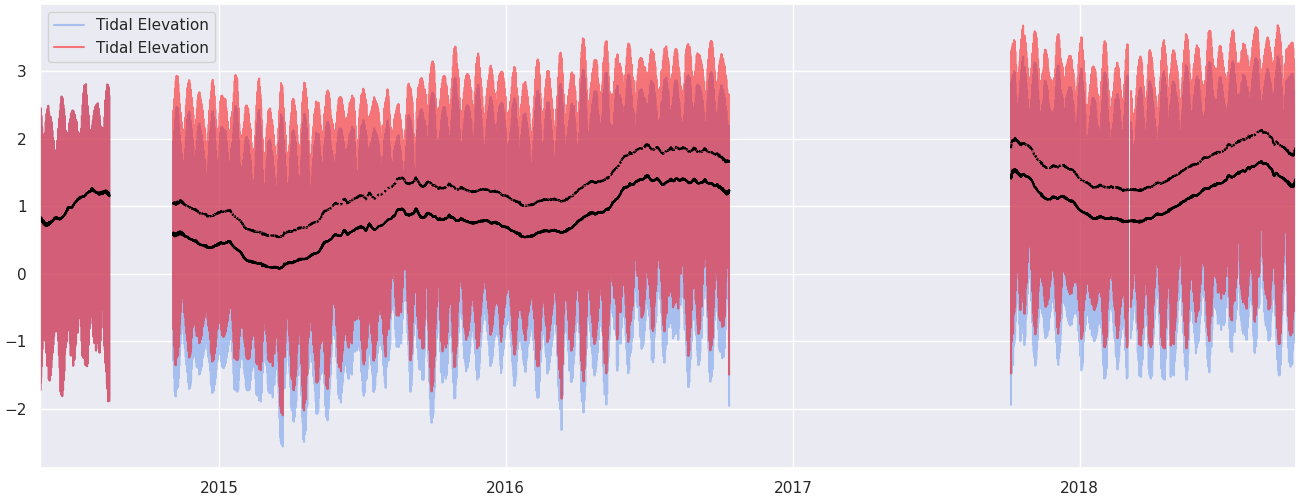

In [162]:
left = data.rolling(window=window, center=True, min_periods=window*0.45 // data.index.freq).median().loc[gap.start]
right = data.rolling(window=window, center=True, min_periods=window*0.45 // data.index.freq).median().loc[gap.end]

offset = left - right
lm_offset = preds[0] - preds[-1]
adj = offset - lm_offset

new = data.copy()

new.loc[gap.end:] = new.loc[gap.end:] + adj

fig, ax = plt.subplots(figsize=(13, 5), constrained_layout=True)

window = pd.Timedelta("14D") * 2

data.iloc[::6].plot(kind="line", ax=ax, label="Tidal Elevation", legend=True, color="cornflowerblue", alpha=0.5)
new.iloc[::6].plot(kind="line", ax=ax, label="Tidal Elevation", legend=True, color="red", alpha=0.5)

data.rolling(window=window, center=True, min_periods=int(window/2/data.index.freq)).median().iloc[::6].plot(kind="line", ax=ax, color="black")
new.rolling(window=window, center=True, min_periods=int(window/2/data.index.freq)).median().iloc[::6].plot(kind="line", ax=ax, color="black", ls=":")

ax.set_xlim(data.index[0], data.index[-1])
ax.set_xlabel("");


In [163]:
data = new

In [250]:
data.to_csv(wdir / "processed" / "sutarkhali_adjusted.csv", index="datetime")

<AxesSubplot:>

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
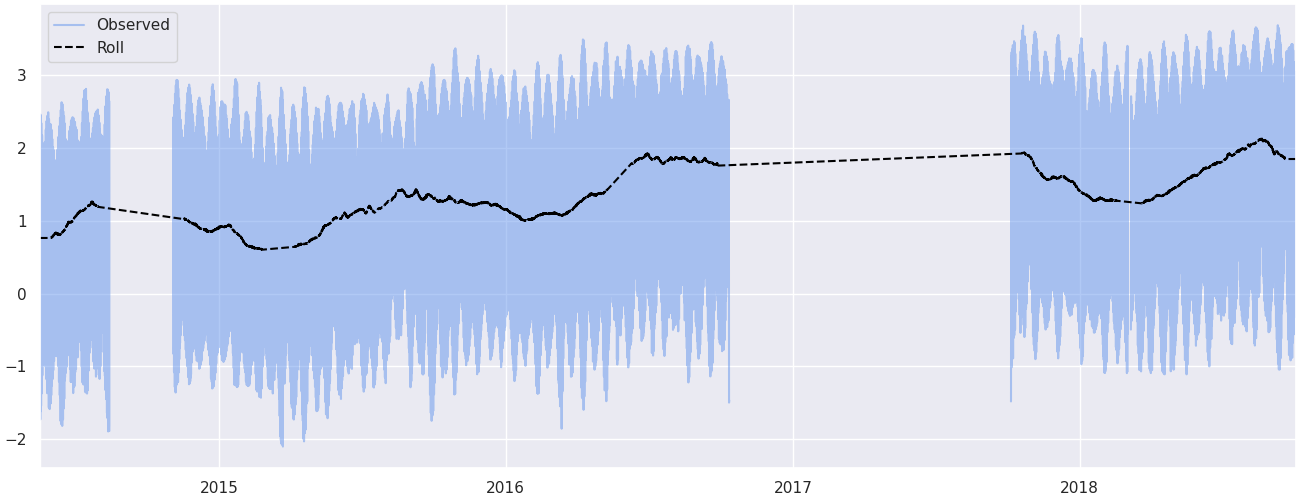

In [164]:
tides = data.to_frame(name="obs")

window = pd.Timedelta("28D")
min_periods = window / 1 // tides.index.freq

tides["roll"] = tides.obs.rolling(window=window, center=True, min_periods=min_periods).median().interpolate(method="time", limit_direction="both")

fig, ax = plt.subplots(figsize=(13, 5), constrained_layout=True)

step = 6

tides.iloc[::step].obs.plot(kind="line", color="cornflowerblue", alpha=0.5, ax=ax, label="Observed", legend=True)
tides.iloc[::step].roll.plot(kind="line", ax=ax, color="black", label="Roll", ls="--", legend=True)

<AxesSubplot:>

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
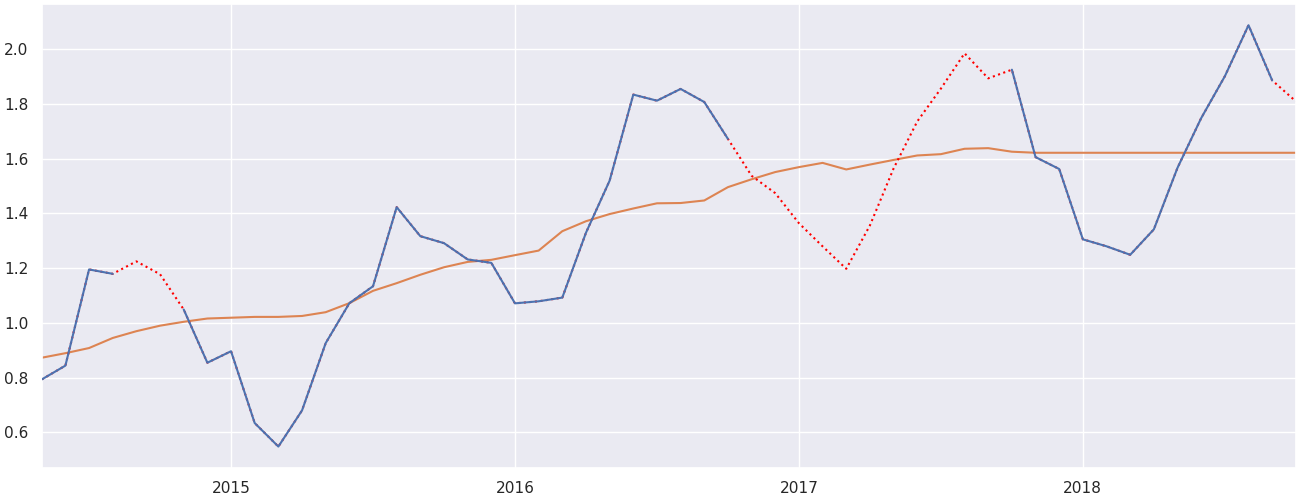

In [208]:
fig, ax = plt.subplots(figsize=(13, 5), constrained_layout=True)

yearly = tides.obs.groupby(by=tides.index.year).agg("median")
monthly = tides.obs.groupby(by=pd.Grouper(freq="MS")).agg(vals="median", nulls=lambda x: 1 - x.count() / (7*24*60/10))
monthly.loc[monthly.nulls > 0.3, "vals"] = np.nan
monthly.vals.plot(ax=ax, zorder=10)
trend = monthly.vals.rolling(window=pd.Timedelta("365.25D") * 2, center=True).mean()
trend.plot(ax=ax)
monthly.vals = monthly.vals - trend
mean_monthly = monthly.vals.groupby(monthly.index.month).mean()
monthly.loc[monthly.nulls > 0.3, "vals"] = mean_monthly.loc[monthly.loc[monthly.nulls > 0.3].index.month].values
monthly = monthly.vals + trend

monthly.plot(ax=ax, color="red", ls=":")


/opt/conda/envs/python/lib/python3.9/site-packages/statsmodels/tsa/seasonal.py:338: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
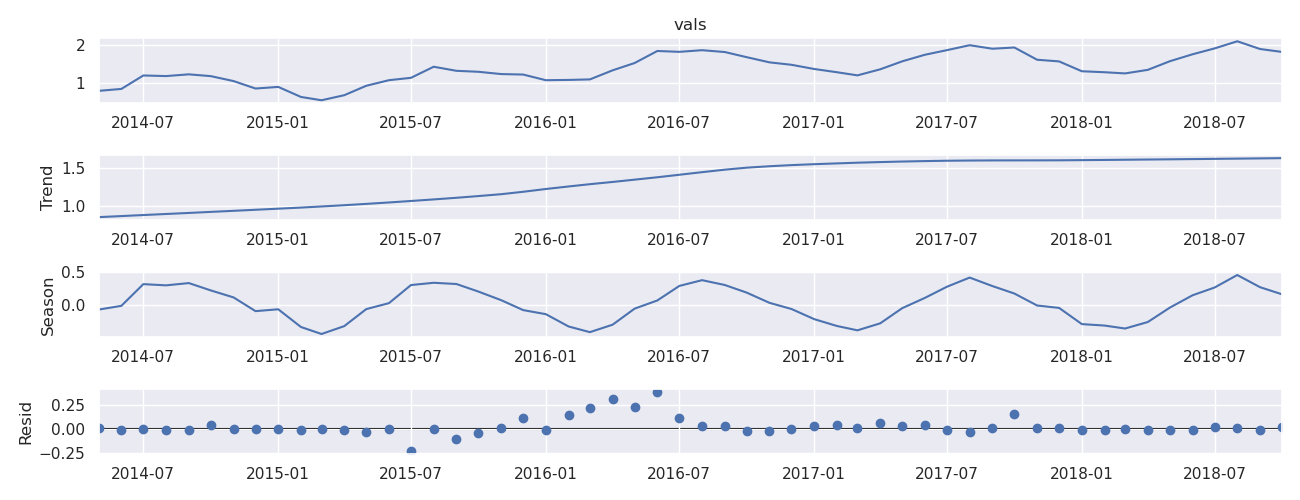

In [209]:
stl = STL(endog=monthly, seasonal=13, robust=True)
res = stl.fit()

tides["seasonal"] = res.seasonal.reindex(index=tides.index).interpolate(method="time", limit_direction="both")
tides["trend"] = res.trend.reindex(index=tides.index).interpolate(method="time", limit_direction="both")
mean_seasonal = tides.seasonal.groupby(tides.index.month).mean()

res.plot();

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
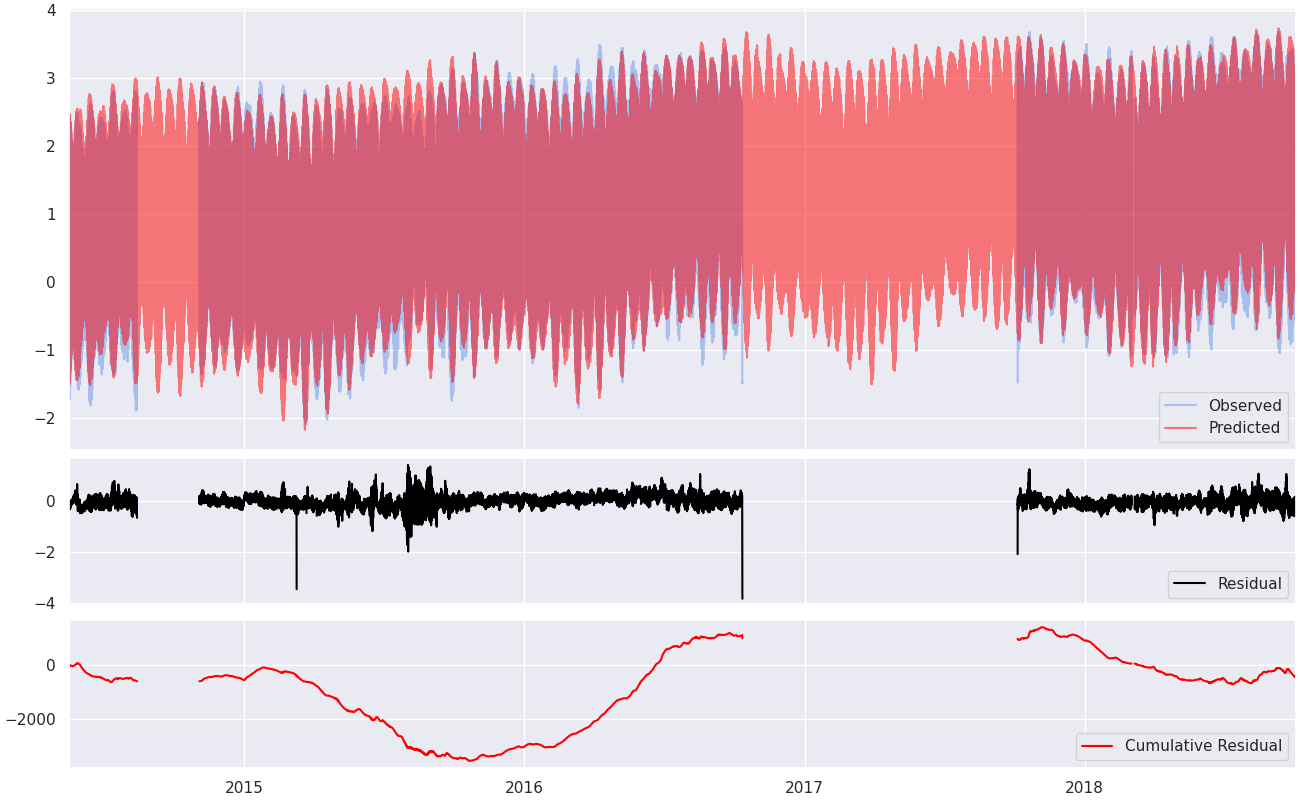

In [236]:
lat = 22.49984514299519
subset = tides
elev = (subset.obs - subset.trend - subset.seasonal).values
time = mdates.date2num((subset.index - pd.Timedelta("6 hours")).to_pydatetime())

coef = utide.solve(t=time, u=elev, lat=lat, conf_int="MC", method="ols", trend=True, nodal=True, constit="auto", verbose=False)
tides["pred"] = utide.reconstruct(t=mdates.date2num((data.index - pd.Timedelta("6 hours")).to_pydatetime()), coef=coef, verbose=False).h + tides.trend + mean_seasonal.loc[tides.index.month].values
tides["res"] = tides.obs - tides.pred

fig, (ax1, ax2, ax3) = plt.subplots(figsize=(13, 8), nrows=3, ncols=1, sharex=True, gridspec_kw={'height_ratios': [3, 1, 1]}, constrained_layout=True)

step = 6

tides.iloc[::step].obs.plot(kind="line", color="cornflowerblue", alpha=0.5, ax=ax1, label="Observed", legend=True)
tides.iloc[::step].pred.plot(kind="line", color="red", alpha=0.5, ax=ax1, label="Predicted", legend=True)
tides.iloc[::step].res.plot(kind="line", ax=ax2, color="black", label="Residual", legend=True)
tides.res.cumsum().iloc[::step].plot(kind="line", ax=ax3, color="red", label="Cumulative Residual", legend=True)

ax3.set_xlim(tides.index[0], tides.index[-1]);
ax3.set_xlabel("");

ax1.legend(loc='lower right')
ax2.legend(loc='lower right')
ax3.legend(loc='lower right')